In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv("df_with_emotions.csv")

In [3]:
df["Gender"] = le.fit_transform(df["Gender"])
df.head()

,Student_ID,Age,Gender,GPA,Stress_Level,Anxiety_Score,Depression_Score,Daily_Reflections,Sleep_Hours,Steps_Per_Day,...,fear,anger,anticipation,trust,surprise,sadness,joy,disgust,negative,positive
0,1,1.159999,2,-0.566791,1.354829,1.607159,-0.916966,Onto foreign do environmental anyone every nea...,0.483148,-0.963883,...,-0.589006,-0.403906,-0.754115,-0.959785,-0.409189,-0.401565,-0.739343,0.000000,5.918226,-1.297918
1,2,-0.601579,1,-0.138201,1.354829,-1.074594,-0.796598,Party but others visit admit industry country ...,-0.633426,-0.566872,...,-0.589006,-0.403906,-0.754115,-0.959785,-0.409189,-0.401565,-0.739343,0.000000,-0.558704,2.905716
2,3,0.279210,0,1.400826,1.354829,0.187407,1.249664,Religious sure wait do chance decade according...,1.468360,0.793510,...,-0.589006,-0.403906,0.977859,-0.959785,2.005550,-0.401565,-0.739343,0.000000,1.060529,-0.247009
3,4,-1.041973,1,-1.501896,0.655743,0.818408,0.045981,A task effect entire coach join series.,1.402679,-0.263157,...,-0.589006,-0.403906,-0.754115,1.588991,-0.409189,-0.401565,-0.739343,0.000000,-0.558704,0.803899
4,5,-0.601579,2,0.115057,-1.441515,-1.232344,-1.157703,Knowledge several camera wait week write quali...,-0.107979,-1.201176,...,-0.589006,0.271686,0.311715,-0.175546,0.333807,-0.401565,0.895866,0.076923,0.437747,-0.651205


In [4]:
X = df.drop(columns=['Mental_Health_Status', 'Daily_Reflections', 'Student_ID', 'Stress_Level', 'Depression_Score', 'Anxiety_Score'])
Y = df['Mental_Health_Status']
X.head()

,Age,Gender,GPA,Sleep_Hours,Steps_Per_Day,fear,anger,anticipation,trust,surprise,sadness,joy,disgust,negative,positive
0,1.159999,2,-0.566791,0.483148,-0.963883,-0.589006,-0.403906,-0.754115,-0.959785,-0.409189,-0.401565,-0.739343,0.000000,5.918226,-1.297918
1,-0.601579,1,-0.138201,-0.633426,-0.566872,-0.589006,-0.403906,-0.754115,-0.959785,-0.409189,-0.401565,-0.739343,0.000000,-0.558704,2.905716
2,0.279210,0,1.400826,1.468360,0.793510,-0.589006,-0.403906,0.977859,-0.959785,2.005550,-0.401565,-0.739343,0.000000,1.060529,-0.247009
3,-1.041973,1,-1.501896,1.402679,-0.263157,-0.589006,-0.403906,-0.754115,1.588991,-0.409189,-0.401565,-0.739343,0.000000,-0.558704,0.803899
4,-0.601579,2,0.115057,-0.107979,-1.201176,-0.589006,0.271686,0.311715,-0.175546,0.333807,-0.401565,0.895866,0.076923,0.437747,-0.651205


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [6]:
model = LogisticRegression(random_state=42, solver='lbfgs')
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'max_iter': [200, 500, 1000]
}

In [7]:
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train, y_train)

,estimator,LogisticRegre...ndom_state=42)
,param_grid,"{'C': [0.0001, 0.001, ...], 'max_iter': [200, 500, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,penalty,'l2'


In [8]:
results = pd.DataFrame(grid_search.cv_results_)

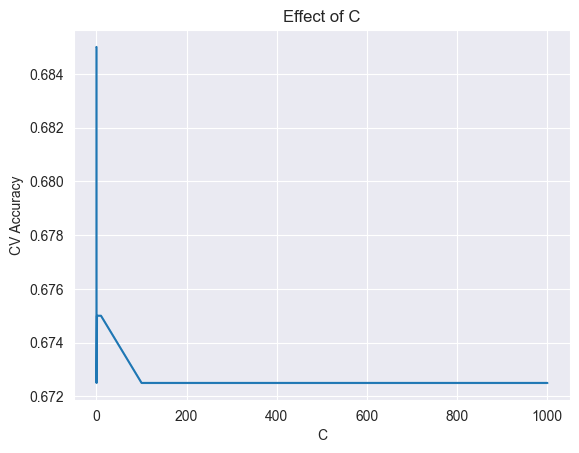

In [9]:
sns.lineplot(x='param_C', y='mean_test_score', data=results)
plt.title("Effect of C")
plt.ylabel("CV Accuracy")
plt.xlabel("C")
plt.show()

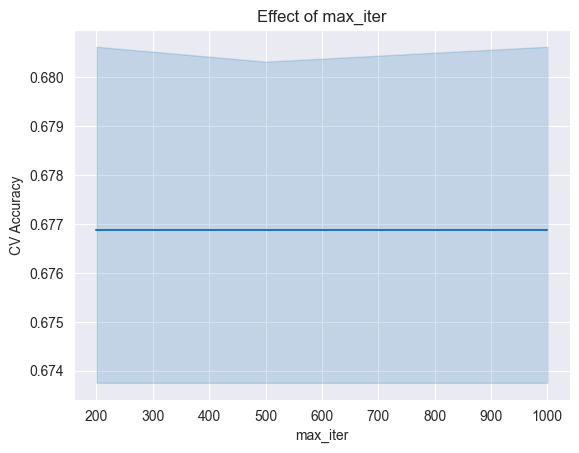

In [10]:
sns.lineplot(x='param_max_iter', y='mean_test_score', data=results)
plt.title("Effect of max_iter")
plt.ylabel("CV Accuracy")
plt.xlabel("max_iter")
plt.show()

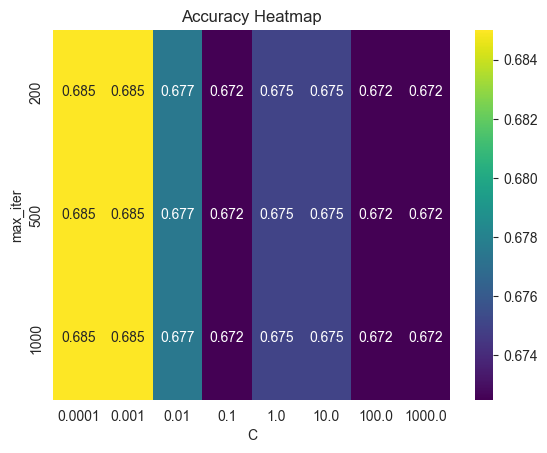

In [11]:
pivot = results.pivot_table(index='param_max_iter',
                             columns='param_C',
                             values='mean_test_score')

sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Accuracy Heatmap")
plt.xlabel("C")
plt.ylabel("max_iter")
plt.show()

In [12]:
model = LogisticRegression(random_state=42, C = 0.1, max_iter = 1000)

In [14]:
scores = cross_val_score(model, X_train, y_train, cv= 10, scoring='accuracy')
print("Accuracy scores for each fold:", scores)
print("Average accuracy:", scores.mean())

Accuracy scores for each fold: [0.7   0.675 0.7   0.625 0.65  0.675 0.675 0.675 0.675 0.7  ]
Average accuracy: 0.675


In [15]:
#data is already scaled
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [16]:
y_test_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy:", accuracy)

Accuracy: 0.67


In [16]:
# Logistic Regression - actual training accuracy values
# [% of data used to train, accuracy value, changed parameter values]
# 70% - 0.82
# 70% - 0.8267 - C = 0.1, max_iter = 1000
# 70% - 0.84 - C = 10, max_iter = 500
# 70% - 0.84 - C = 100, max_iter = 500
# 75% - 0.848
# 75% - 0.832 - C = 0.1, max_iter = 1000
# 75% - 0.84 - C = 10, max_iter = 500
# 75% - 0.84 - C = 10, max_iter = 200
# 80% - 0.87
# 80% - 0.86 - C = 0.1, max_iter = 1000
# 80% - 0.87 - C = 100, max_iter = 500
# 80% - 0.87 - C = 100, max_iter = 200
# 85% - 0.866
# 85% - 0.88 - C = 0.1, max_iter = 1000
# 85% - 0.853 - C = 10, max_iter = 1000
# 90% - 0.84
# 90% - 0.86 - C = 0.1, max_iter = 1000
# Logistic Regression - cross validation training accuracy values
# [% of data used to train, accuracy value, changed parameter values]
# 70% - 0.806
# 70% - 0.804 - C = 0.1, max_iter = 1000
# 70% - 0.8 - C = 10, max_iter = 500
# 70% - 0.796 - C = 100, max_iter = 500
# 75% - 0.806
# 75% - 0.804 - C = 0.1, max_iter = 1000
# 75% - 0.8 - C = 10, max_iter = 500
# 75% - 0.8 - C = 10, max_iter = 200
# 80% - 0.806
# 80% - 0.804 - C = 0.1, max_iter = 1000
# 80% - 0.796 - C = 100, max_iter = 500
# 80% - 0.796 - C = 100, max_iter = 200
# 85% - 0.806
# 85% - 0.804 - C = 0.1, max_iter = 1000
# 85% - 0.8 - C = 10, max_iter = 1000
# 90% - 0.806
# 90% - 0.804 - C = 0.1, max_iter = 1000

# random_number for all = 42
# if no parameter is there then it's the default value
# 80% training is best, low C value is ideal, high C value can lead to overfitting
# Best: 80% training, C = 0.1, max_iter = 1000